In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# !pip install -q jupyter
!pip install -q matplotlib
!pip install -q fastai
# !pip install -q wget
!pip install -q kornia
!pip install -q opencv-python
!pip install -q scipy
!pip install -q numpy
!pip install -q torchvision
!pip install -q tensorboardX
!pip install -q tqdm

In [3]:
# from PIL import Image
# import numpy
# import transforms

# x= Image.open('/kaggle/input/mvtecad-mvtec-anomaly-detection/mvtec_anomaly_detection/hazelnut/test/good/000.png').convert('RGBA')
# transform = transforms.Compose([transforms.PILToTensor()])
# tensor = transform(x)

In [4]:
import torch
import torch.nn.functional as F
import random

def DiffAugment(x, policy='', channels_first=True):
    if policy:
        if not channels_first:
            x = x.permute(0, 3, 1, 2)
        for p in policy.split(','):
            for f in AUGMENT_FNS[p]:
                x = f(x)
        if not channels_first:
            x = x.permute(0, 2, 3, 1)
        x = x.contiguous()
    return x


def rand_brightness(x):
    x = x + (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) - 0.5)
    return x


def rand_saturation(x):
    x_mean = x.mean(dim=1, keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) * 2) + x_mean
    return x


def rand_contrast(x):
    x_mean = x.mean(dim=[1, 2, 3], keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) + 0.5) + x_mean
    return x


def rand_translation(x, ratio=0.2):
    shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    translation_x = torch.randint(-shift_x, shift_x + 1, size=[x.size(0), 1, 1], device=x.device)
    translation_y = torch.randint(-shift_y, shift_y + 1, size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(x.size(2), dtype=torch.long, device=x.device),
        torch.arange(x.size(3), dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
    grid_y = torch.clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
    x_pad = F.pad(x, [1, 1, 1, 1, 0, 0, 0, 0])
    x = x_pad.permute(0, 2, 3, 1).contiguous()[grid_batch, grid_x, grid_y].permute(0, 3, 1, 2)
    return x


def rand_cutout(x, ratio=0.5):
    if random.random() < 0.3:
        cutout_size = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
        offset_x = torch.randint(0, x.size(2) + (1 - cutout_size[0] % 2), size=[x.size(0), 1, 1], device=x.device)
        offset_y = torch.randint(0, x.size(3) + (1 - cutout_size[1] % 2), size=[x.size(0), 1, 1], device=x.device)
        grid_batch, grid_x, grid_y = torch.meshgrid(
            torch.arange(x.size(0), dtype=torch.long, device=x.device),
            torch.arange(cutout_size[0], dtype=torch.long, device=x.device),
            torch.arange(cutout_size[1], dtype=torch.long, device=x.device),
        )
        grid_x = torch.clamp(grid_x + offset_x - cutout_size[0] // 2, min=0, max=x.size(2) - 1)
        grid_y = torch.clamp(grid_y + offset_y - cutout_size[1] // 2, min=0, max=x.size(3) - 1)
        mask = torch.ones(x.size(0), x.size(2), x.size(3), dtype=x.dtype, device=x.device)
        mask[grid_batch, grid_x, grid_y] = 0
        x = x * mask.unsqueeze(1)
    return x

def rand_rotate(x, ratio=0.5):
    k = random.randint(1,3)
    if random.random() < ratio:
        x = torch.rot90(x, k, [2,3])
    return x

AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
    'rotate': [rand_rotate],
}

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time

import os

import numpy as np


def noise(n_samples, z_dim, device):
        return torch.randn(n_samples,z_dim).to(device)
    
class LinearLrDecay(object):
    def __init__(self, optimizer, start_lr, end_lr, decay_start_step, decay_end_step):

        assert start_lr > end_lr
        self.optimizer = optimizer
        self.delta = (start_lr - end_lr) / (decay_end_step - decay_start_step)
        self.decay_start_step = decay_start_step
        self.decay_end_step = decay_end_step
        self.start_lr = start_lr
        self.end_lr = end_lr

    def step(self, current_step):
        if current_step <= self.decay_start_step:
            lr = self.start_lr
        elif current_step >= self.decay_end_step:
            lr = self.end_lr
        else:
            lr = self.start_lr - self.delta * (current_step - self.decay_start_step)
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr
        return lr

def inits_weight(m):
        if type(m) == nn.Linear:
                nn.init.xavier_uniform(m.weight.data, 1.)


def noise(imgs, latent_dim):
        return torch.FloatTensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim)))

def gener_noise(gener_batch_size, latent_dim):
        return torch.FloatTensor(np.random.normal(0, 1, (gener_batch_size, latent_dim)))

def save_checkpoint(states,is_best, output_dir,
                    filename='checkpoint.pth'):
    torch.save(states, os.path.join(output_dir, filename))
    if is_best:
        torch.save(states, os.path.join(output_dir, 'checkpoint_best.pth'))

In [6]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, in_feat, hid_feat=None, out_feat=None,
                 dropout=0.):
        super().__init__()
        if not hid_feat:
            hid_feat = in_feat
        if not out_feat:
            out_feat = in_feat
        self.fc1 = nn.Linear(in_feat, hid_feat)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hid_feat, out_feat)
        self.droprateout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return self.droprateout(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=4, attention_dropout=0., proj_dropout=0.):
        super().__init__()
        self.heads = heads
        self.scale = 1./dim**0.5

        self.qkv = nn.Linear(dim, dim*3, bias=False)
        self.attention_dropout = nn.Dropout(attention_dropout)
        self.out = nn.Sequential(
            nn.Linear(dim, dim),
            nn.Dropout(proj_dropout)
        )

    def forward(self, x):
        b, n, c = x.shape
        qkv = self.qkv(x).reshape(b, n, 3, self.heads, c//self.heads)
        q, k, v = qkv.permute(2, 0, 3, 1, 4)

        dot = (q @ k.transpose(-2, -1)) * self.scale
        attn = dot.softmax(dim=-1)
        attn = self.attention_dropout(attn)

        x = (attn @ v).transpose(1, 2).reshape(b, n, c)
        x = self.out(x)
        return x

class ImgPatches(nn.Module):
    def __init__(self, input_channel=3, dim=768, patch_size=4):
        super().__init__()
        self.patch_embed = nn.Conv2d(input_channel, dim,
                                     kernel_size=patch_size, stride=patch_size)

    def forward(self, img):
        patches = self.patch_embed(img).flatten(2).transpose(1, 2)
        return patches

def UpSampling(x, H, W):
        B, N, C = x.size()
        assert N == H*W
        x = x.permute(0, 2, 1)
        x = x.view(-1, C, H, W)
        x = nn.PixelShuffle(2)(x)
        B, C, H, W = x.size()
        x = x.view(-1, C, H*W)
        x = x.permute(0,2,1)
        return x, H, W

class Encoder_Block(nn.Module):
    def __init__(self, dim, heads, mlp_ratio=4, drop_rate=0.):
        super().__init__()
        self.ln1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, heads, drop_rate, drop_rate)
        self.ln2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, dim*mlp_ratio, dropout=drop_rate)

    def forward(self, x):
        x1 = self.ln1(x)
        x = x + self.attn(x1)
        x2 = self.ln2(x)
        x = x + self.mlp(x2)
        return x


class TransformerEncoder(nn.Module):
    def __init__(self, depth, dim, heads, mlp_ratio=4, drop_rate=0.):
        super().__init__()
        self.Encoder_Blocks = nn.ModuleList([
            Encoder_Block(dim, heads, mlp_ratio, drop_rate)
            for i in range(depth)])

    def forward(self, x):
        for Encoder_Block in self.Encoder_Blocks:
            x = Encoder_Block(x)
        return x

class Generator(nn.Module):
    """docstring for Generator"""
    def __init__(self, depth1=4, depth2=3, depth3=1, initial_size=8, dim=384, heads=4, mlp_ratio=4, drop_rate=0.):#,device=device):
        super(Generator, self).__init__()

        #self.device = device
        self.initial_size = initial_size
        self.dim = dim
        self.depth1 = depth1
        self.depth2 = depth2
        self.depth3 = depth3
        self.heads = heads
        self.mlp_ratio = mlp_ratio
        self.droprate_rate =drop_rate

        self.mlp = nn.Linear(1024, (self.initial_size ** 2) * self.dim)

        self.positional_embedding_1 = nn.Parameter(torch.zeros(1, (self.initial_size**2), 384))
        self.positional_embedding_2 = nn.Parameter(torch.zeros(1, (self.initial_size*2)**2, 384//4))
        self.positional_embedding_3 = nn.Parameter(torch.zeros(1, (self.initial_size*4)**2, 384//16))

        self.TransformerEncoder_encoder1 = TransformerEncoder(depth=self.depth1, dim=self.dim,heads=self.heads, mlp_ratio=self.mlp_ratio, drop_rate=self.droprate_rate)
        self.TransformerEncoder_encoder2 = TransformerEncoder(depth=self.depth2, dim=self.dim//4, heads=self.heads, mlp_ratio=self.mlp_ratio, drop_rate=self.droprate_rate)
        self.TransformerEncoder_encoder3 = TransformerEncoder(depth=self.depth3, dim=self.dim//16, heads=self.heads, mlp_ratio=self.mlp_ratio, drop_rate=self.droprate_rate)


        self.linear = nn.Sequential(nn.Conv2d(self.dim//16, 3, 1, 1, 0)) #changed channel size to 4 (from 3)

    def forward(self, noise):

        x = self.mlp(noise).view(-1, self.initial_size ** 2, self.dim)

        x = x + self.positional_embedding_1
        H, W = self.initial_size, self.initial_size
        x = self.TransformerEncoder_encoder1(x)

        x,H,W = UpSampling(x,H,W) 
        x = x + self.positional_embedding_2
        x = self.TransformerEncoder_encoder2(x)

        x,H,W = UpSampling(x,H,W)
        x = x + self.positional_embedding_3

        x = self.TransformerEncoder_encoder3(x)
        x = self.linear(x.permute(0, 2, 1).view(-1, self.dim//16, H, W))

        return x

class Discriminator(nn.Module):
    def __init__(self, diff_aug, image_size=32, patch_size=4, input_channel=3, num_classes=1,
                 dim=384, depth=4, heads=4, mlp_ratio=4,
                 drop_rate=0.):
        super().__init__()
        if image_size % patch_size != 0:
            raise ValueError('Image size must be divisible by patch size.')
        num_patches = (image_size//patch_size) ** 2
        self.diff_aug = diff_aug
        self.patch_size = patch_size
        self.depth = depth
        # Image patches and embedding layer
        self.patches = ImgPatches(input_channel, dim, self.patch_size)

        # Embedding for patch position and class
        self.positional_embedding = nn.Parameter(torch.zeros(1, num_patches+1, dim))
        self.class_embedding = nn.Parameter(torch.zeros(1, 1, dim))
        nn.init.trunc_normal_(self.positional_embedding, std=0.2)
        nn.init.trunc_normal_(self.class_embedding, std=0.2)

        self.droprate = nn.Dropout(p=drop_rate)
        self.TransfomerEncoder = TransformerEncoder(depth, dim, heads,
                                      mlp_ratio, drop_rate)
        self.norm = nn.LayerNorm(dim)
        self.out = nn.Linear(dim, num_classes)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        x = DiffAugment(x, self.diff_aug)
        b = x.shape[0]
        cls_token = self.class_embedding.expand(b, -1, -1)

        x = self.patches(x)
        x = torch.cat((cls_token, x), dim=1)
        x += self.positional_embedding
        x = self.droprate(x)
        x = self.TransfomerEncoder(x)
        x = self.norm(x)
        x = self.out(x[:, 0])
        return x

In [7]:
import sys, os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np


In [8]:
data_path=Path('/kaggle/input/mvtecad-mvtec-anomaly-detection/mvtec_anomaly_detection')
dset='toothbrush'

In [9]:
list((data_path/dset).glob('*'))

[PosixPath('/kaggle/input/mvtecad-mvtec-anomaly-detection/mvtec_anomaly_detection/toothbrush/readme.txt'),
 PosixPath('/kaggle/input/mvtecad-mvtec-anomaly-detection/mvtec_anomaly_detection/toothbrush/ground_truth'),
 PosixPath('/kaggle/input/mvtecad-mvtec-anomaly-detection/mvtec_anomaly_detection/toothbrush/license.txt'),
 PosixPath('/kaggle/input/mvtecad-mvtec-anomaly-detection/mvtec_anomaly_detection/toothbrush/test'),
 PosixPath('/kaggle/input/mvtecad-mvtec-anomaly-detection/mvtec_anomaly_detection/toothbrush/train')]

In [10]:
list((data_path/dset/'train').glob('*'))

[PosixPath('/kaggle/input/mvtecad-mvtec-anomaly-detection/mvtec_anomaly_detection/toothbrush/train/good')]

In [11]:
im_paths=list((data_path/dset/'train'/'good').glob('*'))
im_paths[:5]

[PosixPath('/kaggle/input/mvtecad-mvtec-anomaly-detection/mvtec_anomaly_detection/toothbrush/train/good/043.png'),
 PosixPath('/kaggle/input/mvtecad-mvtec-anomaly-detection/mvtec_anomaly_detection/toothbrush/train/good/038.png'),
 PosixPath('/kaggle/input/mvtecad-mvtec-anomaly-detection/mvtec_anomaly_detection/toothbrush/train/good/027.png'),
 PosixPath('/kaggle/input/mvtecad-mvtec-anomaly-detection/mvtec_anomaly_detection/toothbrush/train/good/053.png'),
 PosixPath('/kaggle/input/mvtecad-mvtec-anomaly-detection/mvtec_anomaly_detection/toothbrush/train/good/007.png')]

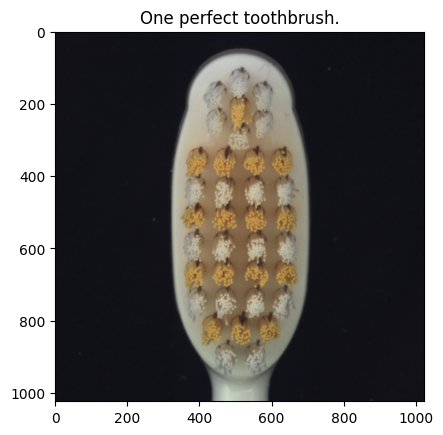

In [12]:
plt.imshow(plt.imread(str(im_paths[0])))
plt.title('One perfect toothbrush.');

### 1. Data Loaders for Training

We’ll be using a few python libraries of note here: PyTorch, kornia, and fastai. There’s of course other fantastic tools out there like Tensorflow and Keras - PyTorch and fastai have been my go to for the last 2 years or so, especially for getting stuff up and running quickly. 


In [13]:
from torch.utils.data import Dataset
from PIL import Image

class CustomImageDataset(Dataset):
  """
  Custom dataset class for images without labels.
  """
  def __init__(self, data_path, transform=None):
    """
    Args:
        data_path (str): Path to the directory containing images.
        transform (transforms.Compose, optional): Transformation to apply to images. Defaults to None.
    """
    self.data_path = data_path
    self.image_paths = [str(p) for p in Path(data_path).glob("*")]  # Modify for your image format
    self.transform = transform

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    image_path = self.image_paths[idx]
    image = Image.open(image_path) # Use PIL.Image for reading images
    if self.transform:
      image = self.transform(image)
    return image

In [14]:

import kornia
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

# Might want to suppress warnings 
import warnings
warnings.filterwarnings('ignore')

batch_size, im_size, channels = 8, 64, 3

# Define transformations (assuming no rand_pad)
transform = transforms.Compose([
    transforms.Resize((im_size,im_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5,0.5)),  # Normalize to [0, 1] and subtract mean
])

dataset = CustomImageDataset((data_path/dset/'train'/'good'), transform=transform)
# Create the data loader with batch size 64
data_loader = DataLoader(dataset, batch_size=8, shuffle=False)

print(dataset[0].shape)

# Example usage to access a batch of images
images = next(iter(data_loader))
print(images.shape)

torch.Size([3, 64, 64])
torch.Size([8, 3, 64, 64])


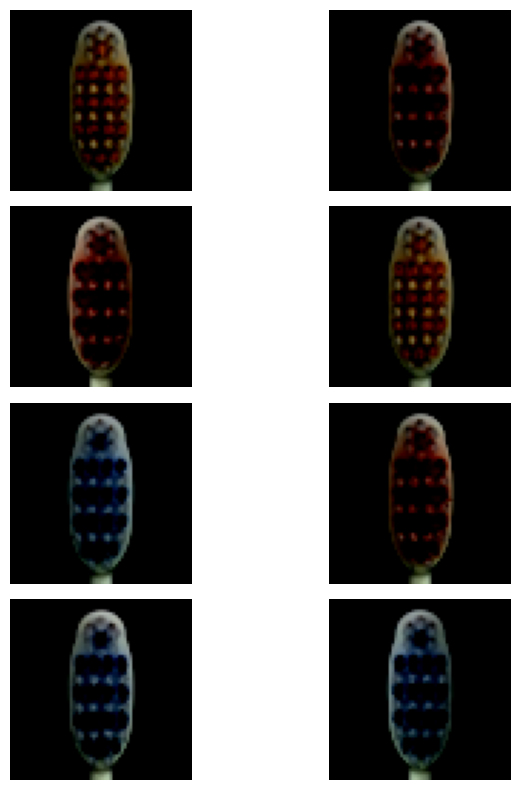

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to show a grid of images
def show_image_grid(images, figsize=(8, 8)):
  """
  Displays a grid of images from a given tensor.

  Args:
      images (torch.Tensor): The tensor containing the images (shape: [batch_size, channels, height, width]).
      figsize (tuple, optional): The desired figure size for the plot. Defaults to (8, 8).
  """
  num_images = images.shape[0]
  rows = 4
  cols = int(np.ceil(num_images / rows))

  fig, axs = plt.subplots(rows, cols, figsize=figsize)

  for i in range(num_images):
    axs[int(i / cols), i % cols].imshow(images[i].permute(1, 2, 0))  # Permute to (channels, height, width)
    axs[int(i / cols), i % cols].axis('off')

  plt.tight_layout()
  plt.show()

# Get a sample batch of images
images = next(iter(data_loader))

# Show the sample batch
show_image_grid(images)


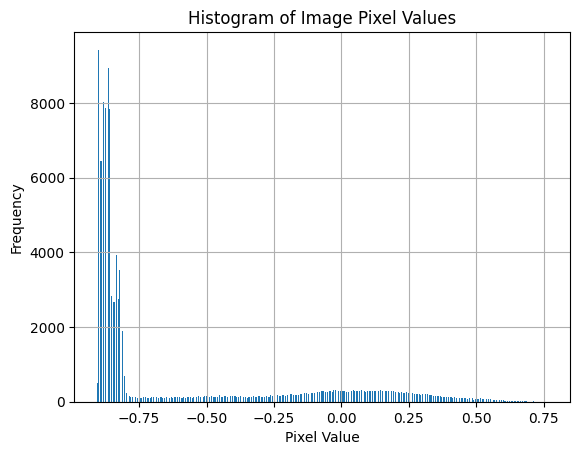

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Get a sample batch of images (assuming your data loader is named "data_loader")
images = next(iter(data_loader))

# Convert the batch to a NumPy array and reshape to flatten the image data
image_data = images.numpy().reshape(-1)  # Reshape to 1D for histogram

# Plot the histogram
plt.hist(image_data, bins=384);  # Use your desired number of bins
plt.grid(True)
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.title("Histogram of Image Pixel Values")
plt.show()


In [17]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') #Do we have a GPU?
# defaults.device = device
print(device)

cuda


In [18]:
G = Generator(depth1=4, depth2=3, depth3=1, initial_size=16, dim=384, heads=4, mlp_ratio=4, drop_rate=0.5).to(device)


In [19]:
D = Discriminator(diff_aug = "translation,cutout,color", image_size=64, patch_size=4, input_channel=3, num_classes=1,
                 dim=384, depth=4, heads=4, mlp_ratio=4,
                 drop_rate=0.).to(device)

In [20]:
# checkpoint = torch.load('/kaggle/input/notebook85d1a2effa/checkpoint.pth')

In [21]:
#print(len(checkpoint))

In [22]:
# G.load_state_dict(checkpoint['generator_state_dict'])

In [23]:
# D.load_state_dict(checkpoint['discriminator_state_dict'])

In [24]:
z = torch.cuda.FloatTensor(np.random.normal(0, 1, (1, 1024)))

In [25]:
fake=G(z.to(device))
fake.shape

torch.Size([1, 3, 64, 64])

In [26]:
D(fake)

tensor([[0.1807]], device='cuda:0', grad_fn=<AddmmBackward0>)

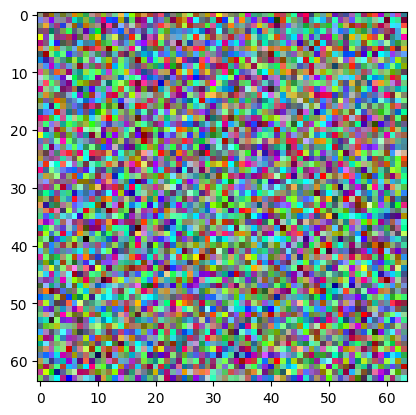

In [27]:
plt.imshow((kornia.tensor_to_image(G(z)+1)/2))

In [28]:
x = next(iter(data_loader))
x.shape

torch.Size([8, 3, 64, 64])

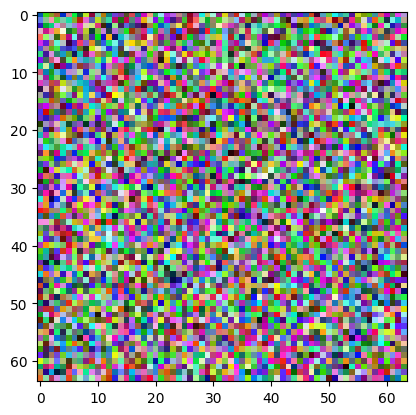

In [29]:
import cv2
# fake = G(z.to(device))
plt.imshow(transforms.ToPILImage()(fake[0].detach())); plt.grid(0)
# cv2.cvtColor(fake, cv2.COLOR_BGR2RGB)

In [30]:
out=D(x.to(device))

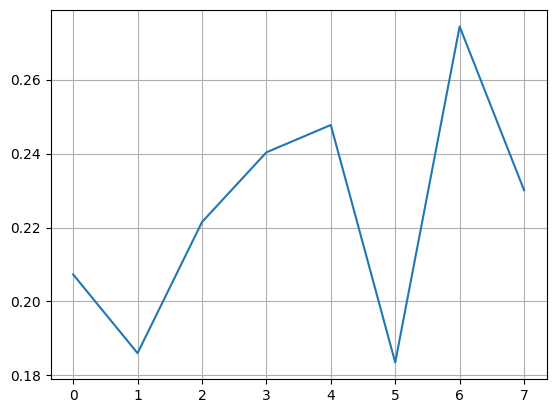

In [31]:
plt.plot(out.detach().cpu()); plt.grid(1)

### 4. Training Time

Alright, now that we have our data loader, discriminator, and generator set up, we can train out model! It's really helpful to have some visualization as we train, especially to see if the fake image the generator is creating look convincing. Let's start by creating a performance visualization method to show performance as we train. We'll keep track of a few key visuals while training. First, we'll choose a z_fized - 25 randomly chosen and static points in our latent space. At each visualization step, we'll pass these 25 points through our generator, and see how our fake images look. As we train, our random noise should start to be shaped into hazelnuts! Secondly, we'll plot a histogram of the pixel intensity of our fake images G(z) and compare these to our histograms of the pixel intensity values in our real images x. As we train, these distributions should look more and more similar. Finally, we'll also visualiztion our Generator and Discrimanator loss functions as we train - we should hopefully see a healthy back and forth, if either model consistenly wins, it's unlikely our fake images will look anything like real ones!

In [32]:
from torch import optim
from tqdm import tqdm
from IPython import display
import matplotlib.gridspec as gridspec

In [33]:
save_training_viz=True
save_dir=Path('kaggle/working/export') #Location to save training visualzations
(save_dir/'viz').mkdir(exist_ok=True, parents=True)
(save_dir/'ckpts').mkdir(exist_ok=True, parents=True)

In [34]:
def show_progress(save=False):
    '''Visualization method to see how were doing'''
    plt.clf(); fig=plt.figure(0, (24, 12)); gs=gridspec.GridSpec(6, 12)
    with torch.no_grad(): fake=G(z_fixed)
    for j in range(8):
        fig.add_subplot(gs[(j//6), j%6])
        plt.imshow((kornia.tensor_to_image(fake[j])+1)/2); plt.axis('off')
    ax=fig.add_subplot(gs[5, :4]); plt.hist(fake.detach().cpu().numpy().ravel(), 100, facecolor='xkcd:crimson')
    ax.get_yaxis().set_ticks([]); plt.xlabel('$G(z)$', fontsize=16); plt.xlim([-1, 1])
    ax=fig.add_subplot(gs[5, 4:7]); plt.hist(x.cpu().numpy().ravel(), 100, facecolor='xkcd:purple')
    ax.get_yaxis().set_ticks([]); plt.xlabel('$x$', fontsize=16)
    fig.add_subplot(gs[:,7:])
    plt.plot(losses[0], color='xkcd:goldenrod', linewidth=2); plt.plot(losses[1], color='xkcd:sea blue', linewidth=2); 
    plt.legend(['Discriminator', 'Generator'],loc=1, fontsize=16); 
    plt.grid(1); plt.title('Epoch = ' + str(epoch), fontsize=16); plt.ylabel('loss', fontsize=16); plt.xlabel('iteration', fontsize=16);
    display.clear_output(wait=True); display.display(plt.gcf())
    if save: plt.savefig(save_dir/'viz'/(str(epoch)+'.png'), dpi=150)

In [35]:
G.apply(inits_weight)
D.apply(inits_weight)

Discriminator(
  (patches): ImgPatches(
    (patch_embed): Conv2d(3, 384, kernel_size=(4, 4), stride=(4, 4))
  )
  (droprate): Dropout(p=0.0, inplace=False)
  (TransfomerEncoder): TransformerEncoder(
    (Encoder_Blocks): ModuleList(
      (0-3): 4 x Encoder_Block(
        (ln1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=False)
          (attention_dropout): Dropout(p=0.0, inplace=False)
          (out): Sequential(
            (0): Linear(in_features=384, out_features=384, bias=True)
            (1): Dropout(p=0.0, inplace=False)
          )
        )
        (ln2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (droprateout): Dropout(p=0.0, inplace=False)
        )

In [36]:
optG = optim.Adam(filter(lambda p: p.requires_grad, G.parameters()), lr=0.0001, betas=(0.0001, 0.9))

optD = optim.Adam(filter(lambda p: p.requires_grad, D.parameters()), lr=0.0001, betas=(0.0001, 0.9))
criterion = nn.BCELoss()

In [37]:
gen_scheduler = LinearLrDecay(optG, 0.0001, 0.0, 0, 500000 * 5)
dis_scheduler = LinearLrDecay(optD, 0.0001, 0.0, 0, 500000 * 5)

In [38]:
def compute_gradient_penalty(D, real_samples, fake_samples, phi):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.Tensor(np.random.random((real_samples.size(0), 1, 1, 1))).to(real_samples.get_device())
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones([real_samples.shape[0], 1], requires_grad=False).to(real_samples.get_device())
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.contiguous().view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - phi) ** 2).mean()
    return gradient_penalty

In [39]:
from __future__ import division
from __future__ import print_function

import time
import argparse
import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import make_grid, save_image

from tensorboardX import SummaryWriter
from tqdm import tqdm
from copy import deepcopy

In [40]:
zero_labels = torch.zeros(batch_size).to(device)
ones_labels = torch.ones(batch_size).to(device)
losses = [[],[]]
epochs, viz_freq, save_freq, count = 300, 100, 500, 0
z_fixed = torch.cuda.FloatTensor(np.random.normal(0, 1, (batch_size, 1024)))

# Default values for arguments
image_size = 64
initial_size = 16
patch_size = 4
num_classes = 1
lr_gen = 0.0001
lr_dis = 0.0001
weight_decay = 1e-3
latent_dim = 1024
n_critic = 5
max_iter = 50000
gener_batch_size = 8
dis_batch_size = 8
epoch = 300
output_dir = '/kaggle/working'
dim = 384
img_name = "img_name"
optim_type = "Adam"
loss_type = "wgangp_eps"
phi = 1
beta1 = 0
beta2 = 0.99
lr_decay = True
diff_aug = "translation,cutout,color"

In [41]:
writer = SummaryWriter()
writer_dict = {'writer': writer}
writer_dict["train_global_steps"] = 0
writer_dict["valid_global_steps"] = 0

In [42]:
os.makedirs('generated_images')

In [43]:
def train(noise, generator, discriminator, optim_gen, optim_dis,
          epoch, writer, schedulers, img_size=image_size, latent_dim=latent_dim,
          n_critic=n_critic,
          gener_batch_size=gener_batch_size, device=device):

    writer = writer_dict['writer']
    gen_step = 0

    generator = generator.train()
    discriminator = discriminator.train()

    transform = transforms.Compose([transforms.Resize(size=(img_size, img_size)), transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    train_loader = data_loader

    for index, img in enumerate(train_loader):

        global_steps = writer_dict['train_global_steps']

        real_imgs = img.type(torch.cuda.FloatTensor)

        noise = torch.cuda.FloatTensor(np.random.normal(0, 1, (img.shape[0], latent_dim)))

        optim_dis.zero_grad()
        real_valid = discriminator(real_imgs)
        fake_imgs = generator(noise).detach()

        fake_valid = discriminator(fake_imgs)

        if loss_type == 'hinge':
            loss_dis = torch.mean(nn.ReLU(inplace=True)(1.0 - real_valid)).to(device) + torch.mean(
                nn.ReLU(inplace=True)(1 + fake_valid)).to(device)
        elif loss_type == 'wgangp_eps':
            gradient_penalty = compute_gradient_penalty(discriminator, real_imgs, fake_imgs.detach(), phi)
            loss_dis = -torch.mean(real_valid) + torch.mean(fake_valid) + gradient_penalty * 10 / (phi ** 2)

        loss_dis.backward(); losses[0].append(loss_dis.item())
        optim_dis.step()

        writer.add_scalar("loss_dis", loss_dis.item(), global_steps)

        if global_steps % n_critic == 0:

            optim_gen.zero_grad()
            if schedulers:
                gen_scheduler, dis_scheduler = schedulers
                g_lr = gen_scheduler.step(global_steps)
                d_lr = dis_scheduler.step(global_steps)
                writer.add_scalar('LR/g_lr', g_lr, global_steps)
                writer.add_scalar('LR/d_lr', d_lr, global_steps)

            gener_noise = torch.cuda.FloatTensor(np.random.normal(0, 1, (gener_batch_size, latent_dim)))

            generated_imgs = generator(gener_noise)
            fake_valid = discriminator(generated_imgs)

            gener_loss = -torch.mean(fake_valid).to(device)
            gener_loss.backward(); losses[1].append(gener_loss.item())
            optim_gen.step()
            writer.add_scalar("gener_loss", gener_loss.item(), global_steps)

            gen_step += 1

        if gen_step and index % 100 == 0:
            sample_imgs = generated_imgs[:25]
            img_grid = make_grid(sample_imgs, nrow=5, normalize=True, scale_each=True)
            save_image(sample_imgs,
                       f'generated_images/generated_img_{epoch}_{index % len(train_loader)}.png', nrow=5, normalize=True,
                       scale_each=True)
            tqdm.write("[Epoch %d] [Batch %d/%d] [D loss: %f] [G loss: %f]" %
                       (epoch + 1, index % len(train_loader), len(train_loader), loss_dis.item(), gener_loss.item()))
            show_progress(True)
            # Show progress in Tensorboard
            writer.add_image('Generated Images', img_grid, global_steps)


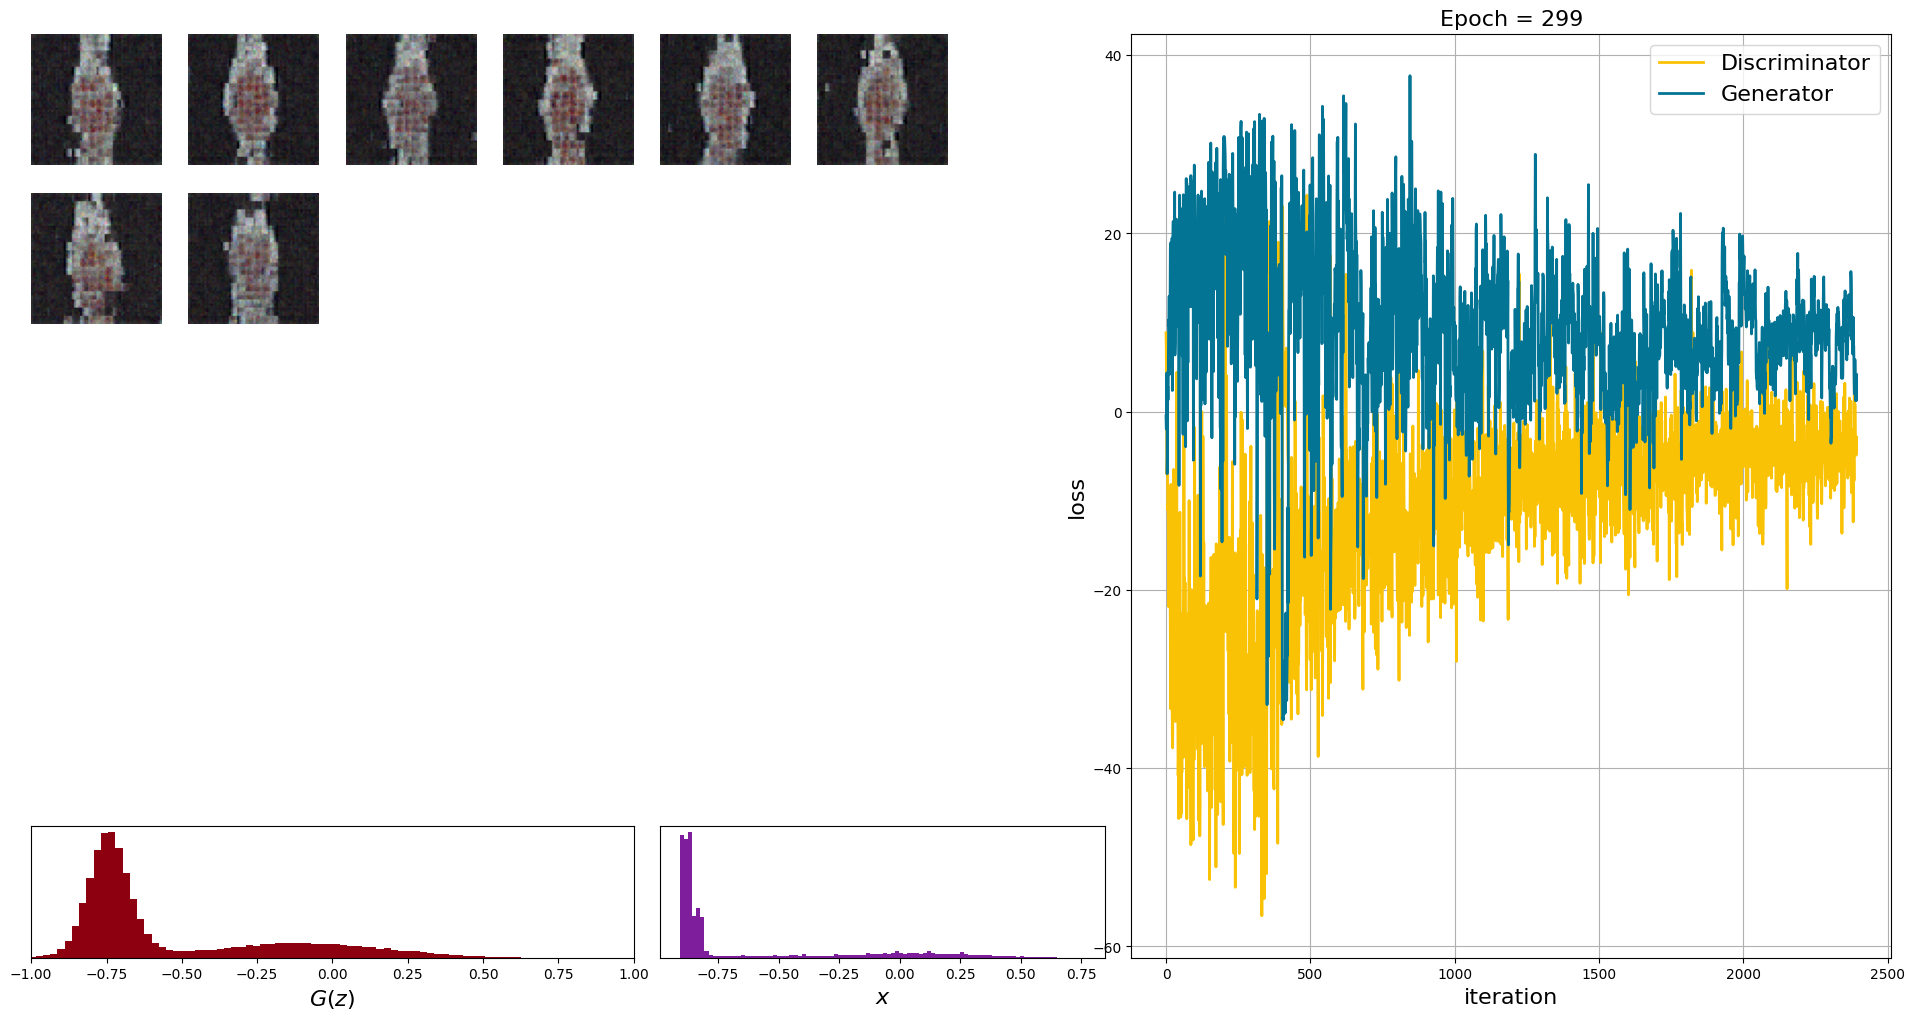

<Figure size 640x480 with 0 Axes>

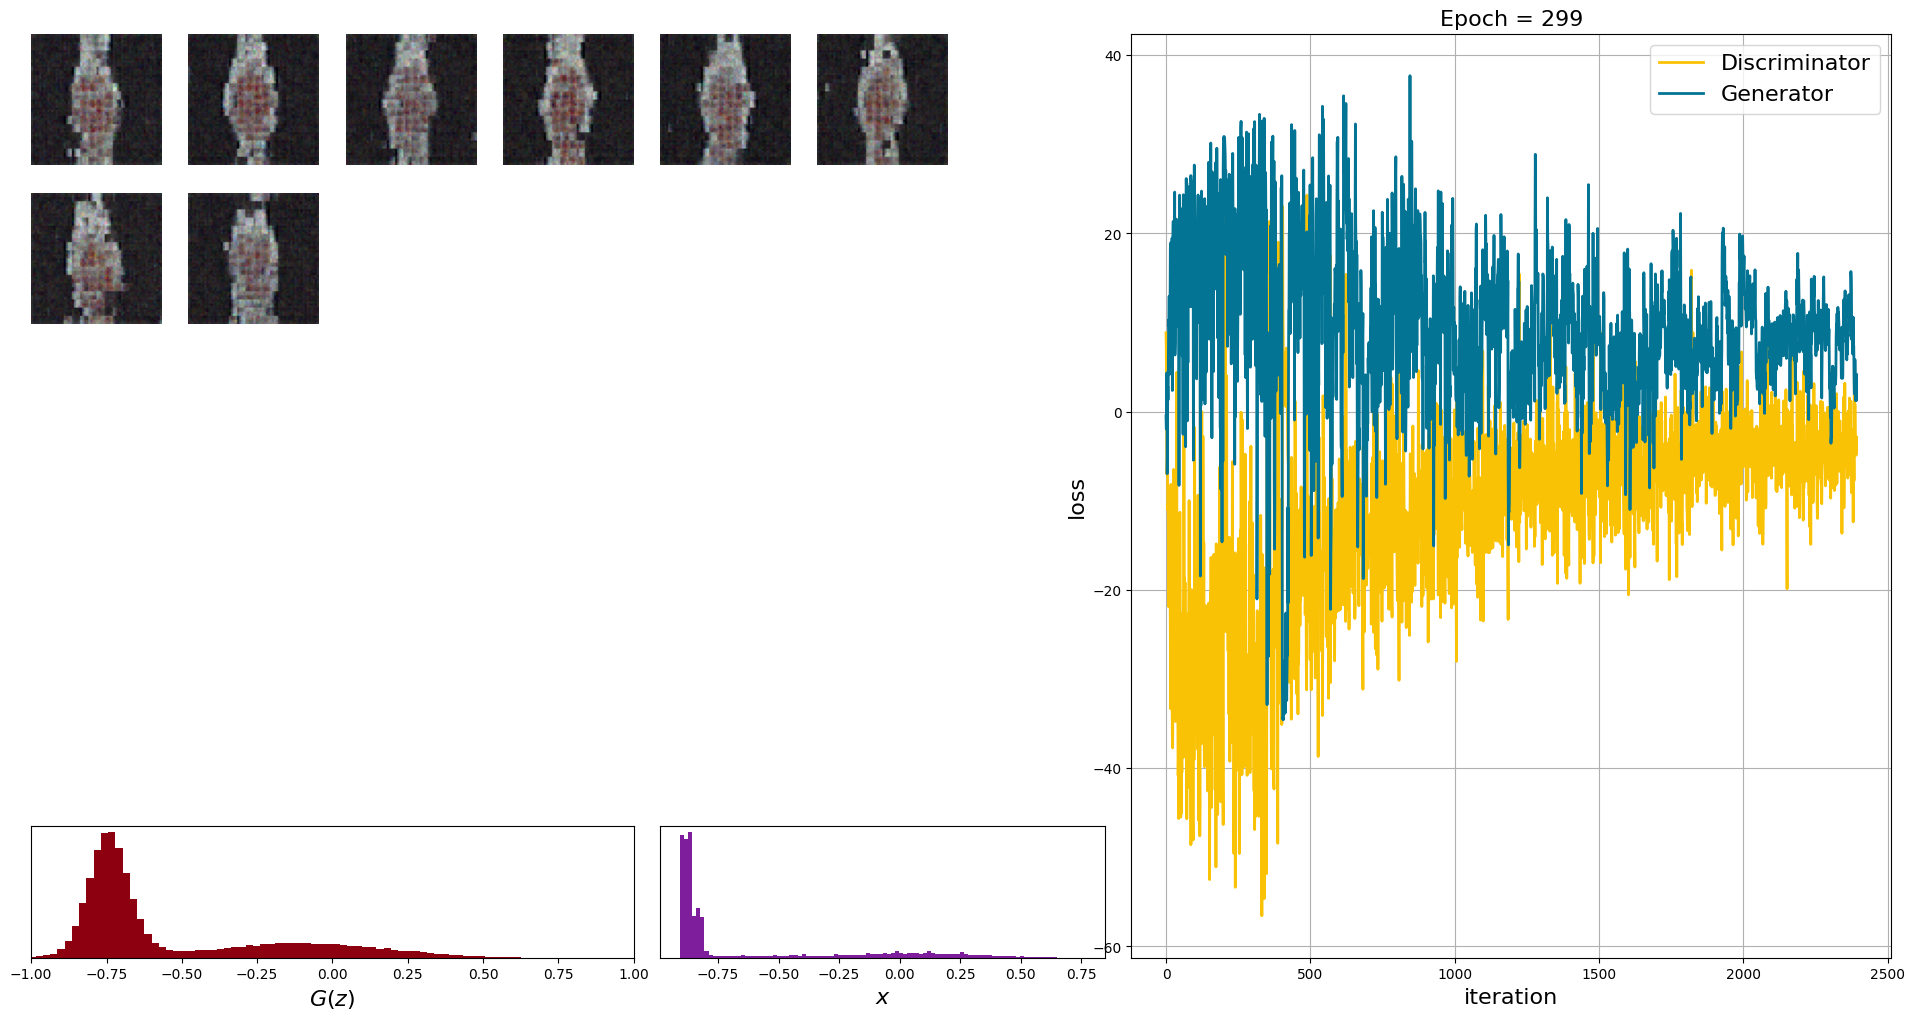

In [44]:
best_fid = 1e4
print(epoch)
for epoch in range(epochs):
    
#     print(ep)
    lr_schedulers = (gen_scheduler, dis_scheduler) if lr_decay else None

    train(noise=torch.randn(gener_batch_size, latent_dim, 1, 1).to(device), generator=G,
          discriminator=D, optim_gen=optG, optim_dis=optD,
          epoch=epoch, writer=writer, schedulers=lr_schedulers, img_size=image_size, latent_dim=latent_dim,
          n_critic=n_critic, gener_batch_size=gener_batch_size)

    # Save checkpoint
    checkpoint = {
        'epoch': epoch,
        'generator_state_dict': G.state_dict(),
        'discriminator_state_dict': D.state_dict()
    }
    save_checkpoint(checkpoint, is_best=False, output_dir=output_dir)

In [45]:
import cv2
dset = 'toothbrush'
im_path=list((data_path/dset/'train'/'good').glob('*'))[1]
im=cv2.cvtColor(cv2.imread(str(im_path)), cv2.COLOR_BGR2RGB)
im=cv2.resize(im, (64,64))
# im= cv2.cvtColor(im,cv2.COLOR_RGB2RGBA)
im.shape

(64, 64, 3)

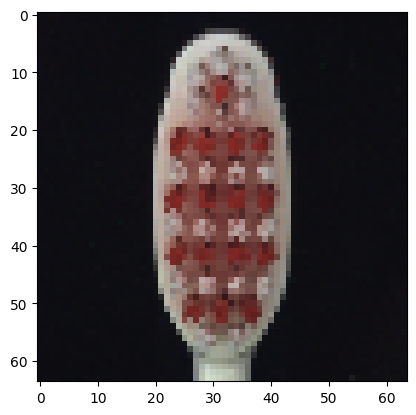

In [46]:
plt.imshow(im)

In [47]:
def toTens(im):
#     print(im.shape)
    if im.shape[-1] == 3:  # Check if already RGB
      im_pil = im
    else:
      im_pil = Image.fromarray(im)  # Convert from OpenCV format (BGR)
    print(im_pil.shape)
    # Define transformations
    transform = transforms.Compose([
      transforms.ToTensor(),  # Convert to tensor first
      transforms.Resize((im_size, im_size)),  # Resize after conversion
#       transforms.RandomHorizontalFlip(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    
    return transform(im_pil)

# Apply transformations and get the normalized tensor
im_tensor = toTens(im)

z = torch.randn(1, 1024, device='cuda', dtype=torch.float, requires_grad=True)
opt=optim.Adam([z], lr=2e-2)

(64, 64, 3)


In [48]:
def combined_l1_l2_loss(output, target, lambda_=0.25):
  """
  Calculates the combined L1/L2 loss with a weighting factor.

  Args:
      output: A torch tensor with the model's output.
      target: A torch tensor with the ground truth values.
      lambda_: Weighting factor for L1 loss (default: 1.0).

  Returns:
      A torch tensor with the combined L1/L2 loss value.
  """
  l1_part = torch.nn.L1Loss()(output, target)
  l2_part = torch.nn.functional.mse_loss(output, target)
  return lambda_ * l1_part + (1.0 - lambda_) * l2_part


In [49]:
# G(z).squeeze(0)
transform_n = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5,0.5))
gz = transform_n(G(z))
# gz

In [50]:
im_tensor

tensor([[[-0.8824, -0.8824, -0.8588,  ..., -0.8980, -0.9059, -0.9059],
         [-0.8745, -0.8824, -0.8588,  ..., -0.8824, -0.9059, -0.9059],
         [-0.8745, -0.8745, -0.8824,  ..., -0.9059, -0.9059, -0.9059],
         ...,
         [-0.9059, -0.9059, -0.8980,  ..., -0.8824, -0.8667, -0.8902],
         [-0.8980, -0.9059, -0.8980,  ..., -0.8902, -0.8824, -0.8745],
         [-0.9059, -0.8980, -0.8980,  ..., -0.8745, -0.8824, -0.8667]],

        [[-0.8902, -0.8824, -0.8745,  ..., -0.9059, -0.9059, -0.8980],
         [-0.8902, -0.8902, -0.8824,  ..., -0.8902, -0.9059, -0.8980],
         [-0.8902, -0.8902, -0.8902,  ..., -0.9059, -0.8980, -0.9059],
         ...,
         [-0.8980, -0.8980, -0.9059,  ..., -0.8745, -0.8824, -0.8824],
         [-0.9059, -0.9059, -0.8980,  ..., -0.8824, -0.8902, -0.8824],
         [-0.9059, -0.9059, -0.8980,  ..., -0.8745, -0.8824, -0.8824]],

        [[-0.8510, -0.8431, -0.8431,  ..., -0.8667, -0.8667, -0.8667],
         [-0.8353, -0.8353, -0.8510,  ..., -0

In [51]:
losses = []
transform_n = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5,0.5))

for i in tqdm(range(1500)):
    global z
    fake = G(z).to("cpu")
#     fake = transform_n(fake)
    loss = combined_l1_l2_loss(fake.squeeze(0),im_tensor)
#     print(loss.shape)
    loss.backward();
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_([z], max_norm=1.0)
#     z.grad.zero_()
    opt.step();
    opt.zero_grad()
    losses.append(loss.item())

100%|██████████| 1500/1500 [01:22<00:00, 18.10it/s]


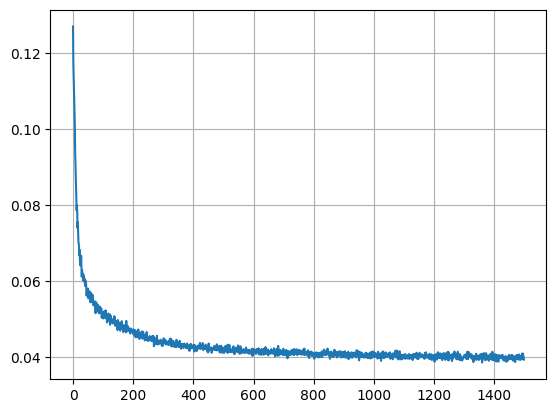

In [52]:
plt.plot(losses); plt.grid(1)

Text(0.5, 1.0, 'Closest Fake Image')

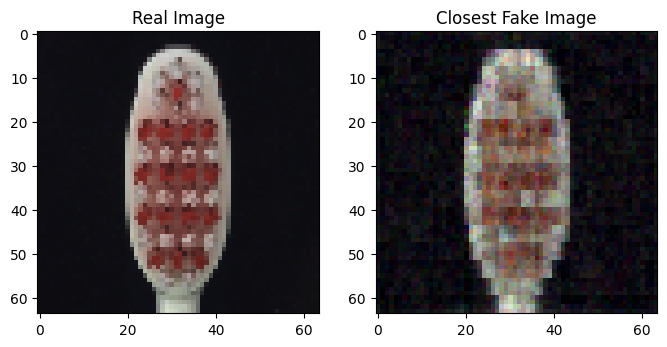

In [53]:
fig=plt.figure(0, (8,4))
fig.add_subplot(1,2,1)
plt.imshow(im); plt.title('Real Image')

fig.add_subplot(1,2,2)
plt.imshow((kornia.tensor_to_image((G(z)+1)/2))); plt.title('Closest Fake Image')

In [54]:
def get_d_loss(f_x, fake, D):
    loss_d = 0
    fx={}
    def hookx(name):
#         print(name)
        def hook_fn(module, input, output):
#             print(name, " f_x = ",f_x[name],"\n---\n")
            fx[name]=output
#             print(name, "f_x = ",f_x[name],"\n--------\nfx = ", fx[name])
        return hook_fn

        # Register hooks to the first 10 layers
    j = 0
    for name, module in D.named_children():
        if  j < 10:
            module.register_forward_hook(hookx(name))
            j += 1
    
#     print(f_x)
#     def hook_fn_fake(module,input, output):
#         print(module._get_name())
#         if module._get_name() in f_x:
#             loss_d += nn.L1Loss()(f_x[module._get_name()],output.clone().detach())
# #             print(loss_d)
#     # Assuming you have already defined the intermediate_representations_fake dictionary

#     # Register the hook for the fake image output
#     for name, module in D.named_modules():
#         print(name)
#         module.register_forward_hook(hook_fn_fake)
    D.eval()
    _ = D(fake)
#     print(fx)
#     print('--')
    for i in f_x.keys():
#         print(f_x[i])
#         print("---",fx[i])
        loss_d += nn.L1Loss()(f_x[i],fx[i])
#     print("loss = ",loss_d)
    return loss_d

In [55]:
import torch.optim as optim
from tqdm import tqdm

def walk_latent_space(G, D, im_tensor, n_iter=1500, lambd=0.001, lr=2e-2, device='cuda'):
    try:
        f_x = {}  # Precompute feature values for all layers of D
        def hook(name):
            def hook_fn(module, input, output):
#                 if name not in f_x:
                    f_x[name] = output
            return hook_fn

        # Register hooks to the first 10 layers
        j = 0
        for name, module in D.named_children():
            if  j < 10:
                module.register_forward_hook(hook(name))
                j += 1
        
        D.eval()
        _ = D(im_tensor.unsqueeze(0).to('cuda'))
        
        d_x = {}
        
        for i in f_x.keys():
            d_x[i] = f_x[i].detach()

        z = torch.randn(1, 1024, device='cuda', dtype=torch.float, requires_grad=True)
        opt=optim.Adam([z], lr= lr)

        losses = []
        loss = 0
        for i in tqdm(range(n_iter)):
            fake = G(z)
            loss_r = combined_l1_l2_loss(fake.squeeze(0).to('cpu'), im_tensor)  # Residual loss
            loss_d = get_d_loss(d_x, fake, D)  # Discriminator loss
            loss = (1 - lambd) * loss_r + lambd * loss_d  # Total loss

            loss.backward()
            torch.nn.utils.clip_grad_norm_([z], max_norm=1.0)

#             z.grad.zero_()
            opt.step()

            # Zero gradients
            opt.zero_grad()
            G.zero_grad()
            D.zero_grad()

            losses.append(loss.item())
    except RuntimeError as e:
            # If other runtime error, raise it
            raise e
    return {'z': z, 'loss': loss.item(), 'loss_r': loss_r.item(), 'loss_d': loss_d.item(), 'losses': losses}

In [56]:
res = walk_latent_space(G, D, im_tensor, n_iter=1000, lambd=0.0001, lr=2e-2, device='cuda')

100%|██████████| 1000/1000 [01:01<00:00, 16.13it/s]


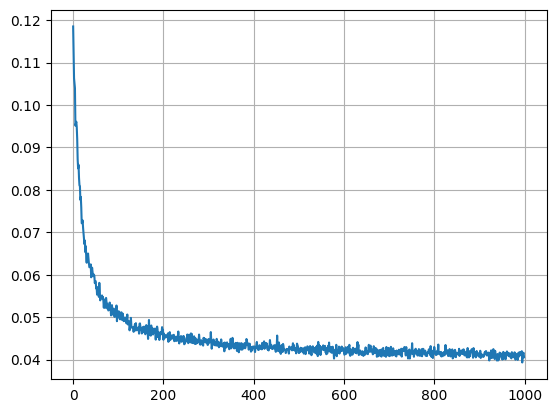

In [57]:
plt.plot(res['losses']); plt.grid(1)

In [58]:
res['loss'], res['loss_d'], res['loss_r']

(0.040532246232032776, 3.813657283782959, 0.040154896676540375)

In [59]:
datapath = '/kaggle/input/mvtecad-mvtec-anomaly-detection/mvtec_anomaly_detection'
im_path=Path(data_path/'toothbrush/test/defective/000.png')
im=cv2.cvtColor(cv2.imread(str(im_path)), cv2.COLOR_BGR2RGB)
im=cv2.resize(im, (64,64))

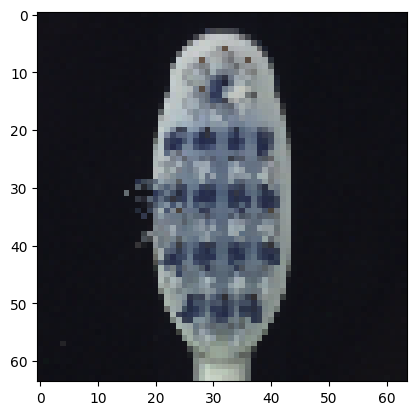

In [60]:
plt.imshow(im)

In [61]:

# Apply transformations and get the normalized tensor
im_tensor = toTens(im)

z = torch.randn(1, 1024, device='cuda', dtype=torch.float, requires_grad=True)
opt=optim.Adam([z], lr=2e-2)

(64, 64, 3)


In [62]:
res=walk_latent_space(G, D, im_tensor, n_iter=1000, lambd=0.0001, lr=2e-2, device='cuda')


100%|██████████| 1000/1000 [01:06<00:00, 15.08it/s]


Text(0.5, 1.0, 'Closest Fake Image')

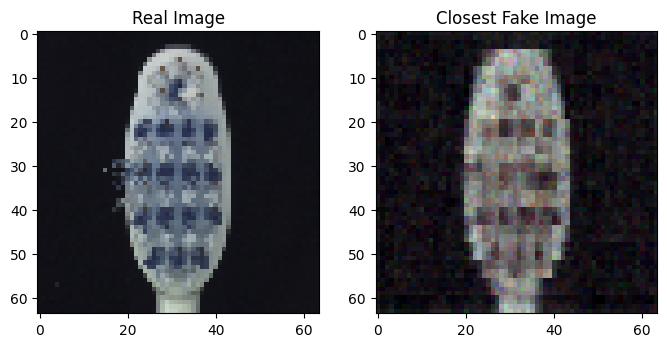

In [63]:
fig=plt.figure(0, (8,4))
fig.add_subplot(1,2,1)
plt.imshow(im); plt.title('Real Image')

fig.add_subplot(1,2,2)
plt.imshow((kornia.tensor_to_image(G(res['z']))+1)/2); plt.title('Closest Fake Image')

In [64]:
xr=np.abs((im.astype('float')/255)-(kornia.tensor_to_image(G(z))+1)/2) #Residual image

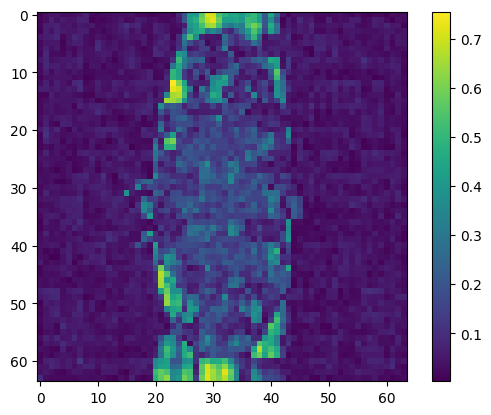

In [65]:
plt.imshow(np.mean(xr, axis=2))
plt.colorbar()

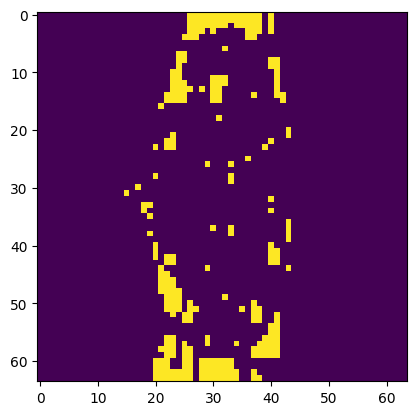

In [66]:
thresh=0.3
plt.imshow(np.mean(xr, axis=2)>=thresh)

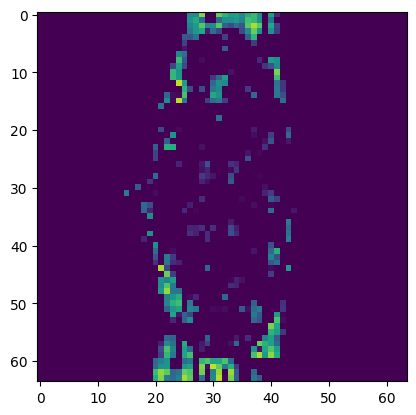

In [67]:
# Mask the array to select values within the range
# Define lower and upper bounds for the desired range
lower_bound = 0.2
upper_bound = 0.65

# Create a mask to select values within the range
mask = (xr >= lower_bound) & (xr <= upper_bound)

# Apply the mask to create a new array with values in range set to 1, others to 0
masked_array = np.where(mask, 1, 0)

# Calculate the mean along axis 2 using the masked array
mean_image = np.mean(masked_array * xr, axis=2)  # Multiply with original array

# Display the mean image using imshow with a custom colormap
# cmap = plt.cm.inferno  # Choose a colormap for visualization (e.g., inferno)
plt.imshow(mean_image, vmin=lower_bound, vmax=upper_bound)


Text(0.5, 1.0, 'Anomalous Region')

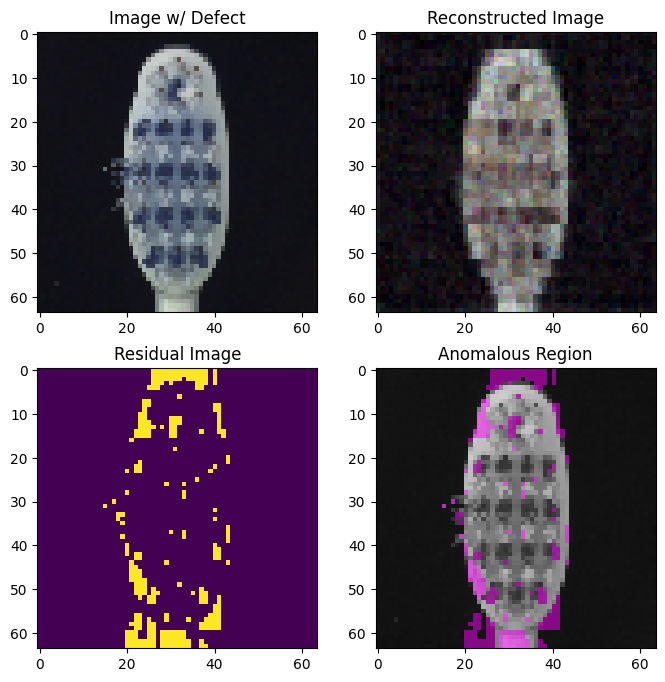

In [68]:
im_mask=np.zeros_like(im)
for i in range(3): im_mask[:,:,i]=np.mean(im, axis=2)
im_mask[np.mean(xr, axis=2)>=thresh]=im_mask[np.mean(xr, axis=2)>thresh]//2+np.array([255,0,255])//2

fig=plt.figure(0, (8,8))
fig.add_subplot(2,2,1); plt.imshow(im); plt.title('Image w/ Defect')
fig.add_subplot(2,2,2); plt.imshow((kornia.tensor_to_image(G(res['z']))+1)/2); plt.title('Reconstructed Image')
fig.add_subplot(2,2,3); plt.imshow(np.mean(xr, axis=2)>=thresh); plt.title('Residual Image')
fig.add_subplot(2,2,4); plt.imshow(im_mask); plt.title('Anomalous Region')

In [69]:
params={'n_iter':200, 'lambd':0.0001, 'lr':2e-2}
all_res=[]
im_paths=[p for p in (data_path/dset/'test').glob('*/*.png')]
for im_path in im_paths:
    im=cv2.cvtColor(cv2.imread(str(im_path)), cv2.COLOR_BGR2RGB)
#     im= cv2.cvtColor(im,cv2.COLOR_RGB2RGBA)
    im_tensor = toTens(im)
    res=walk_latent_space(G, D, im_tensor, **params, device=device)
    res['im_fake']=(kornia.tensor_to_image(G(res['z']))+1)/2 #Scaled between 0 and 1
    res['im_path']=im_path
    res['label']=im_path.parent.name
    all_res.append(res)

(1024, 1024, 3)


100%|██████████| 200/200 [00:13<00:00, 14.32it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:13<00:00, 14.33it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:14<00:00, 14.02it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:14<00:00, 13.63it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:15<00:00, 13.12it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:15<00:00, 13.23it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:15<00:00, 12.79it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:16<00:00, 12.27it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:16<00:00, 12.36it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:16<00:00, 12.43it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:16<00:00, 11.77it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:17<00:00, 11.76it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:17<00:00, 11.49it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:17<00:00, 11.32it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:18<00:00, 10.89it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:18<00:00, 10.73it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:18<00:00, 10.74it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:19<00:00, 10.12it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:20<00:00,  9.87it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:20<00:00,  9.81it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:21<00:00,  9.52it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:21<00:00,  9.43it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:21<00:00,  9.47it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:21<00:00,  9.25it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:22<00:00,  8.83it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:23<00:00,  8.59it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:23<00:00,  8.48it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:24<00:00,  8.18it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:24<00:00,  8.01it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:24<00:00,  8.07it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:25<00:00,  8.00it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:26<00:00,  7.60it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:26<00:00,  7.49it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:26<00:00,  7.42it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:27<00:00,  7.28it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:28<00:00,  7.05it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:28<00:00,  6.95it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:29<00:00,  6.77it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:30<00:00,  6.47it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:30<00:00,  6.54it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:31<00:00,  6.41it/s]


(1024, 1024, 3)


100%|██████████| 200/200 [00:32<00:00,  6.20it/s]


In [70]:
labels=np.unique([res['label'] for res in all_res])
cm={l:i for i,l in enumerate(labels)}

my_cmap={0:'r', 1:'b', 2:'g', 3:'c', 4:'m', 5:'y',6:'r',7:'b',8:'g'}
my_markers={0:'o', 1:'x', 2:'^', 3:'<', 4:'>', 5:'*',6:'^',7:'x',8:'o'}

Text(0, 0.5, 'Residual Loss')

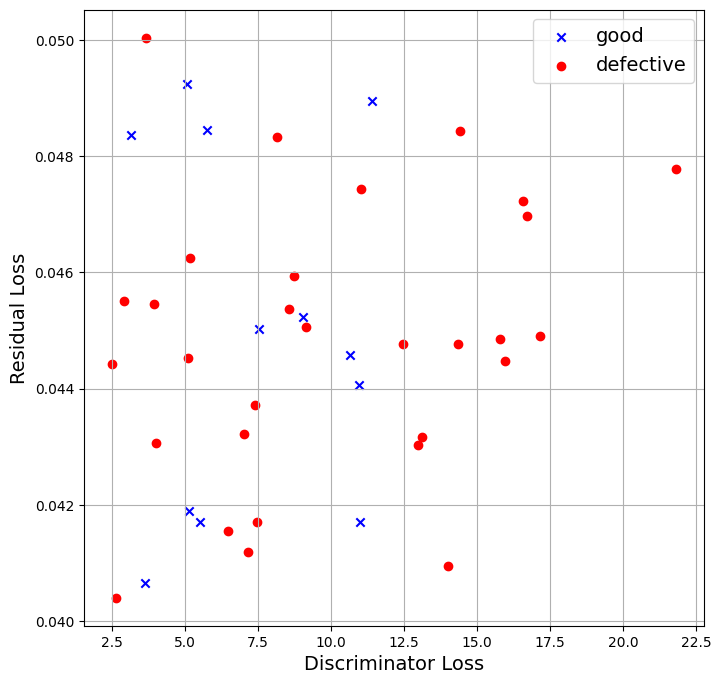

In [71]:
fig=plt.figure(0, (8,8))
handles={}
for res in all_res:
    handles[res['label']]=plt.scatter(res['loss_d'], res['loss_r'], c=my_cmap[cm[res['label']]], marker=my_markers[cm[res['label']]])
plt.legend(handles=handles.values(), labels=handles.keys(), fontsize=14); plt.grid(1)
plt.xlabel('Discriminator Loss', fontsize=14)
plt.ylabel('Residual Loss', fontsize=14)

In [72]:
def anomaly_detector(im, G, D, d_loss_thresh, r_loss_thresh):
    '''Decides if image im is anomalous'''
    im_tensor = toTens(im)
    res=walk_latent_space(G, D, im_tensor, n_iter=200, lambd=0.0001, lr=2e-2, device='cuda')
    if res['loss_d']>d_loss_thresh or res['loss_r']>r_loss_thresh: return True
    else: return False

In [73]:
im_path=data_path/dset/'test'/'good'/'001.png' #Test on good example - should return False
im=cv2.cvtColor(cv2.imread(str(im_path)), cv2.COLOR_BGR2RGB)
im=cv2.resize(im, (64,64))
predicted_anomaly=anomaly_detector(im, G, D, d_loss_thresh=8, r_loss_thresh=0.12)
print(predicted_anomaly)

(64, 64, 3)


100%|██████████| 200/200 [00:32<00:00,  6.22it/s]

False


In [74]:
im_path=data_path/dset/'test'/'defective'/'001.png' #Test on defect - should return True
im=cv2.cvtColor(cv2.imread(str(im_path)), cv2.COLOR_BGR2RGB)
im=cv2.resize(im, (64,64))
predicted_anomaly=anomaly_detector(im, G, D, d_loss_thresh=6, r_loss_thresh=0.11)
print(predicted_anomaly)

(64, 64, 3)


100%|██████████| 200/200 [00:31<00:00,  6.28it/s]

False


In [75]:
# num_correct=0; total=0 #Measure accuracy on good test examples
# for im_path in (data_path/dset/'test'/'good').glob('*.png'):
#     im=cv2.cvtColor(cv2.imread(str(im_path)), cv2.COLOR_BGR2RGB)
#     im=cv2.resize(im, (64,64))
#     predicted_anomaly=anomaly_detector(im, G, D, d_loss_thresh=12, r_loss_thresh=0.12)
#     if not predicted_anomaly: num_correct+=1
#     total+=1
#     print(im_path, predicted_anomaly)

In [76]:
# print("Good images predicted to be good: ", num_correct/total) 

In [77]:
# num_correct=0; total=0 #Measure accuracy on defective test examples
# for im_path in (data_path/dset/'test').glob('*/*'):
#     if 'good' in str(im_path): continue
#     im=cv2.cvtColor(cv2.imread(str(im_path)), cv2.COLOR_BGR2RGB)
#     im=cv2.resize(im, (64,64))
#     predicted_anomaly=anomaly_detector(im, G, D, d_loss_thresh=2.3, r_loss_thresh=0.10)
#     if predicted_anomaly: num_correct+=1
#     total+=1
#     print(im_path, predicted_anomaly)

In [78]:
# print("Anomaly images predicted to be anomalous: ", num_correct/total)